In [3]:
import sys

import matplotlib.pyplot as plt
import PIL
from PIL import Image
import json

import torch
import torchvision
import torchvision.transforms as T

from timm import create_model #using hugging face's timm to create models

In [4]:
# Define transforms for test
from timm.data.constants import \
    IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD

NORMALIZE_MEAN = IMAGENET_DEFAULT_MEAN
NORMALIZE_STD = IMAGENET_DEFAULT_STD
SIZE = 256

# Here we resize smaller edge to 256, no center cropping
transforms = [
              T.Resize(SIZE, interpolation=T.InterpolationMode.BICUBIC),
              T.ToTensor(),
              T.Normalize(NORMALIZE_MEAN, NORMALIZE_STD),
              ]

transforms = T.Compose(transforms)

In [6]:
NORMALIZE_STD

(0.229, 0.224, 0.225)

In [4]:
import json
imagenet_labels = json.load(open(r'D:\aiml projects\Investigation on Vision Language Models\ImageNet\imagenet-1k-simple-labels.json'))

# CONVNEXT BASE 
trained on ImageNet 22k and fine-tuned on ImageNet 1k

In [7]:
model_name = "convnext_base_in22ft1k"

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("device = ", device)

# create a ConvNeXt model : https://github.com/rwightman/pytorch-image-models/blob/master/timm/models/convnext.py
model = create_model(model_name, pretrained=True).to(device)

device =  cuda


c:\Users\Aerof\.conda\envs\PyTorch\Lib\site-packages\timm\models\_factory.py:117: UserWarning: Mapping deprecated model name convnext_base_in22ft1k to current convnext_base.fb_in22k_ft_in1k.
  model = create_fn(


model.safetensors:   0%|          | 0.00/354M [00:00<?, ?B/s]

c:\Users\Aerof\.conda\envs\PyTorch\Lib\site-packages\huggingface_hub\file_download.py:157: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Aerof\.cache\huggingface\hub\models--timm--convnext_base.fb_in22k_ft_in1k. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [8]:
model.eval()

ConvNeXt(
  (stem): Sequential(
    (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
    (1): LayerNorm2d((128,), eps=1e-06, elementwise_affine=True)
  )
  (stages): Sequential(
    (0): ConvNeXtStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): ConvNeXtBlock(
          (conv_dw): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
          (norm): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=128, out_features=512, bias=True)
            (act): GELU()
            (drop1): Dropout(p=0.0, inplace=False)
            (norm): Identity()
            (fc2): Linear(in_features=512, out_features=128, bias=True)
            (drop2): Dropout(p=0.0, inplace=False)
          )
          (shortcut): Identity()
          (drop_path): Identity()
        )
        (1): ConvNeXtBlock(
          (conv_dw): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), g

In [9]:
import os
from tqdm import tqdm_notebook as tqdm
home=r"D:\aiml projects\Investigation on Vision Language Models\ImageNet\imagnet-1k-valid"

predictions=[]
true_label=[]
scores=[]
probabilities=[]

for label in tqdm(os.listdir(home)):
    for img_file in os.listdir(home+"/"+label):
        
        # importing and transforming image
        img=PIL.Image.open(os.path.join(home, label,img_file))
        img_tensor=transforms(img).unsqueeze(0).to(device) 
        
        # getting outputs
        output=model(img_tensor)
        prediction=torch.argmax(output).cpu().tolist()
        score=torch.max(output).cpu().tolist()
        probability=torch.max(torch.softmax(output, dim=1)).cpu().tolist()
        
        # storing outputs in a list
        predictions.append(prediction)
        scores.append(score)
        probabilities.append(probability)
        true_label.append(label)
        

C:\Users\Aerof\AppData\Local\Temp\ipykernel_36024\939338057.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for label in tqdm(os.listdir(home)):


  0%|          | 0/1000 [00:00<?, ?it/s]

In [10]:
# saving the outputs in a csv for future reference
import csv

data=zip(predictions, true_label, scores , probabilities)

with open("evaluated_conv_sup.csv","w") as f:
    writer=csv.writer(f)
    writer.writerows(data)
    print("succesful")
    f.close()

succesful


In [16]:
import pandas as pd

data=pd.read_csv("evaluated_conv_sup.csv")


In [17]:
data=data.dropna(axis=0,how='all')
data=data.reset_index()

In [18]:
data.columns

Index(['index', 'predictions', 'true_label', 'Output', 'probabilities'], dtype='object')

In [19]:
predictions=data['predictions'].to_numpy()
true_label=data['true_label'].to_numpy()
probabilities=data['probabilities'].to_numpy()

In [20]:
#caluculation of ECE

import numpy as np

def expected_calibration_error(predictions, true_label, probabilities, M=15):
    # uniform binning approach with M number of bins
    bin_boundaries = np.linspace(0, 1, M + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]

    
    accuracies= predictions==true_label
    
    ece = np.zeros(1)
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        # determine if sample is in bin m (between bin lower & upper)
        in_bin = np.logical_and(probabilities > bin_lower.item(), probabilities <= bin_upper.item())
        # can calculate the empirical probability of a sample falling into bin m: (|Bm|/n)
        prob_in_bin = in_bin.mean()

        if prob_in_bin.item() > 0:
            # get the accuracy of bin m: acc(Bm)
            accuracy_in_bin = accuracies[in_bin].mean()
            # get the average confidence of bin m: conf(Bm)
            avg_confidence_in_bin = probabilities[in_bin].mean()
            # calculate |acc(Bm) - conf(Bm)| * (|Bm|/n) for bin m and add to the total ECE
            ece += np.abs(avg_confidence_in_bin - accuracy_in_bin) * prob_in_bin
    return ece, accuracies

In [21]:
ECE, accuracies=expected_calibration_error(predictions=predictions, true_label=true_label, probabilities=probabilities)
ECE

array([0.09268744])

In [22]:
accuracies.sum()

42282

d:\aiml projects\Investigation on Vision Language Models\plots.py:176: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_yticklabels(new_ticks)


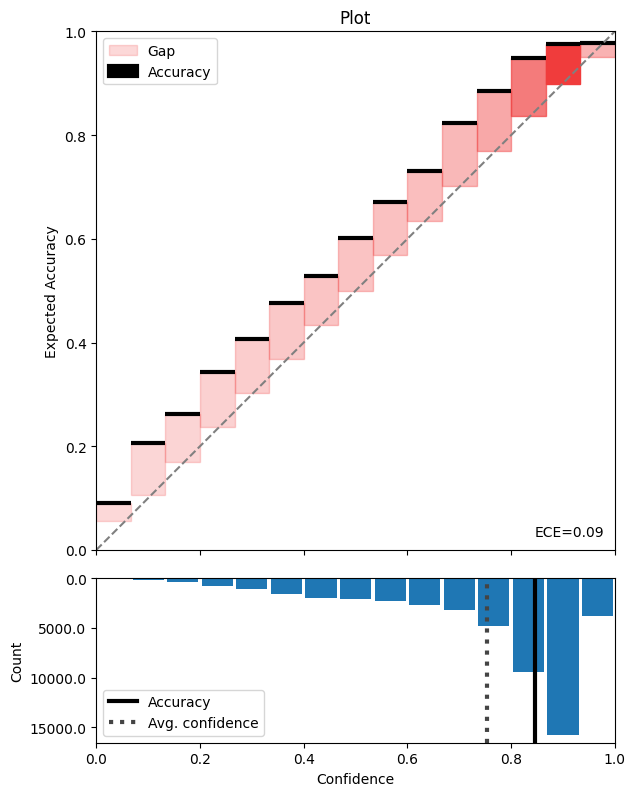

In [23]:
from plots import *

fig=reliability_diagram(true_labels=true_label, pred_labels=predictions, confidences=probabilities,
                        num_bins=15,
                        draw_ece=True,
                        draw_bin_importance="alpha",
                        draw_averages=True,
                        title="Plot", 
                        figsize=(6, 6),
                        dpi=100, 
                        return_fig=True)

# ViT 
Pretrained on Imagenet-21k and fine tuned on Imagenet-1k

In [48]:
model_name = "vit_base_patch16_384.augreg_in21k_ft_in1k"

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("device = ", device)

# create a ViT model : https://github.com/huggingface/pytorch-image-models/blob/main/timm/models/vision_transformer.py
model = create_model(model_name, pretrained=True).to(device)

device =  cuda


model.safetensors:   0%|          | 0.00/347M [00:00<?, ?B/s]

c:\Users\Aerof\.conda\envs\PyTorch\Lib\site-packages\huggingface_hub\file_download.py:157: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Aerof\.cache\huggingface\hub\models--timm--vit_base_patch16_384.augreg_in21k_ft_in1k. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [49]:
model.eval()

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

In [50]:
# Define transforms for test
from timm.data.constants import \
    IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD

NORMALIZE_MEAN = IMAGENET_DEFAULT_MEAN
NORMALIZE_STD = IMAGENET_DEFAULT_STD
SIZE = 384

# Here we resize smaller edge to 256, no center cropping
transforms = [
              T.Resize((SIZE,SIZE), interpolation=T.InterpolationMode.BICUBIC),
              T.ToTensor(),
              T.Normalize(NORMALIZE_MEAN, NORMALIZE_STD),
              ]

transforms = T.Compose(transforms)

In [51]:
import os
from tqdm import tqdm_notebook as tqdm
home=r"D:\aiml projects\Investigation on Vision Language Models\ImageNet\imagnet-1k-valid"

predictions=[]
true_label=[]
scores=[]
probabilities=[]

for label in tqdm(os.listdir(home)):
    for img_file in os.listdir(home+"/"+label):
        
        # importing and transforming image
        img=PIL.Image.open(os.path.join(home, label,img_file))
        img_tensor=transforms(img).unsqueeze(0).to(device) 
        
        # getting outputs
        output=model(img_tensor)
        prediction=torch.argmax(output).cpu().tolist()
        score=torch.max(output).cpu().tolist()
        probability=torch.max(torch.softmax(output, dim=1)).cpu().tolist()
        
        # storing outputs in a list
        predictions.append(prediction)
        scores.append(score)
        probabilities.append(probability)
        true_label.append(label)

C:\Users\Aerof\AppData\Local\Temp\ipykernel_30432\1337197122.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for label in tqdm(os.listdir(home)):


  0%|          | 0/1000 [00:00<?, ?it/s]

In [57]:
# saving the outputs in a csv for future reference
import csv

data=zip(predictions, true_label, scores , probabilities)

with open("evaluated_ViT_sup.csv","w") as f:
    writer=csv.writer(f)
    writer.writerows(data)
    print("succesful")
    f.close()

succesful


In [61]:
import pandas as pd

data=pd.read_csv("evaluated_ViT_sup.csv")

In [62]:
data=data.dropna(axis=0,how='all')
data=data.reset_index()

In [63]:
data.columns

Index(['index', 'predictions', 'true_label', 'Output', 'probabilities'], dtype='object')

In [64]:
predictions=data['predictions'].to_numpy()
true_label=data['true_label'].to_numpy()
probabilities=data['probabilities'].to_numpy()

In [65]:
#caluculation of ECE

import numpy as np

def expected_calibration_error(predictions, true_label, probabilities, M=15):
    # uniform binning approach with M number of bins
    bin_boundaries = np.linspace(0, 1, M + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]

    
    accuracies= predictions==true_label
    
    ece = np.zeros(1)
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        # determine if sample is in bin m (between bin lower & upper)
        in_bin = np.logical_and(probabilities > bin_lower.item(), probabilities <= bin_upper.item())
        # can calculate the empirical probability of a sample falling into bin m: (|Bm|/n)
        prob_in_bin = in_bin.mean()

        if prob_in_bin.item() > 0:
            # get the accuracy of bin m: acc(Bm)
            accuracy_in_bin = accuracies[in_bin].mean()
            # get the average confidence of bin m: conf(Bm)
            avg_confidence_in_bin = probabilities[in_bin].mean()
            # calculate |acc(Bm) - conf(Bm)| * (|Bm|/n) for bin m and add to the total ECE
            ece += np.abs(avg_confidence_in_bin - accuracy_in_bin) * prob_in_bin
    return ece, accuracies

In [66]:
ECE, accuracies=expected_calibration_error(predictions=predictions, true_label=true_label, probabilities=probabilities)
ECE

array([0.01827295])

In [67]:
accuracies.sum()

38660

d:\aiml projects\Investigation on Vision Language Models\plots.py:176: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_yticklabels(new_ticks)


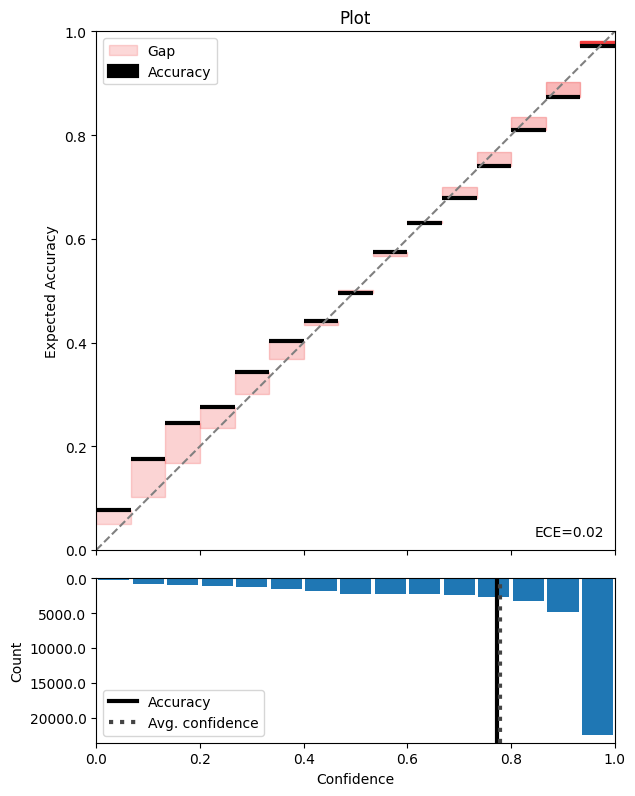

In [68]:
from plots import *

fig=reliability_diagram(true_labels=true_label, pred_labels=predictions, confidences=probabilities,
                        num_bins=15,
                        draw_ece=True,
                        draw_bin_importance="alpha",
                        draw_averages=True,
                        title="Plot", 
                        figsize=(6, 6),
                        dpi=100, 
                        return_fig=True)

# Convnext CLIP

In [5]:
model_name = "convnext_base.clip_laion2b_augreg_ft_in1k"

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("device = ", device)

# create a ConvNeXt model : https://github.com/rwightman/pytorch-image-models/blob/master/timm/models/convnext.py
model = create_model(model_name, pretrained=True).to(device)

device =  cuda


model.safetensors:   0%|          | 0.00/354M [00:00<?, ?B/s]

c:\Users\Aerof\.conda\envs\PyTorch\Lib\site-packages\huggingface_hub\file_download.py:157: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Aerof\.cache\huggingface\hub\models--timm--convnext_base.clip_laion2b_augreg_ft_in1k. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [6]:
model.eval()

ConvNeXt(
  (stem): Sequential(
    (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
    (1): LayerNorm2d((128,), eps=1e-06, elementwise_affine=True)
  )
  (stages): Sequential(
    (0): ConvNeXtStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): ConvNeXtBlock(
          (conv_dw): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
          (norm): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=128, out_features=512, bias=True)
            (act): GELU()
            (drop1): Dropout(p=0.0, inplace=False)
            (norm): Identity()
            (fc2): Linear(in_features=512, out_features=128, bias=True)
            (drop2): Dropout(p=0.0, inplace=False)
          )
          (shortcut): Identity()
          (drop_path): Identity()
        )
        (1): ConvNeXtBlock(
          (conv_dw): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), g

In [8]:
from timm.data import OPENAI_CLIP_MEAN, OPENAI_CLIP_STD

NORMALIZE_MEAN = OPENAI_CLIP_MEAN
NORMALIZE_STD = OPENAI_CLIP_STD
SIZE = 256

# Here we resize smaller edge to 256, no center cropping
transforms = [
              T.Resize(SIZE, interpolation=T.InterpolationMode.BICUBIC),
              T.ToTensor(),
              T.Normalize(NORMALIZE_MEAN, NORMALIZE_STD),
              ]

transforms = T.Compose(transforms)

In [9]:
import os
from tqdm import tqdm_notebook as tqdm
home=r"D:\aiml projects\Investigation on Vision Language Models\ImageNet\imagnet-1k-valid"

predictions=[]
true_label=[]
scores=[]
probabilities=[]

for label in tqdm(os.listdir(home)):
    for img_file in os.listdir(home+"/"+label):
        
        # importing and transforming image
        img=PIL.Image.open(os.path.join(home, label,img_file))
        img_tensor=transforms(img).unsqueeze(0).to(device) 
        
        # getting outputs
        output=model(img_tensor)
        prediction=torch.argmax(output).cpu().tolist()
        score=torch.max(output).cpu().tolist()
        probability=torch.max(torch.softmax(output, dim=1)).cpu().tolist()
        
        # storing outputs in a list
        predictions.append(prediction)
        scores.append(score)
        probabilities.append(probability)
        true_label.append(label)
        

C:\Users\Aerof\AppData\Local\Temp\ipykernel_30432\939338057.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for label in tqdm(os.listdir(home)):


  0%|          | 0/1000 [00:00<?, ?it/s]

In [10]:
# saving the outputs in a csv for future reference
import csv

data=zip(predictions, true_label, scores , probabilities)

with open("evaluated_convnext_clip.csv","w") as f:
    writer=csv.writer(f)
    writer.writerows(data)
    print("succesful")
    f.close()

succesful


In [11]:
import pandas as pd

data=pd.read_csv("evaluated_convnext_clip.csv")


In [12]:
data=data.dropna(axis=0,how='all')
data=data.reset_index()

In [13]:
data.columns

Index(['index', 'predictions', 'true_label', 'Output', 'probabilities'], dtype='object')

In [14]:
predictions=data['predictions'].to_numpy()
true_label=data['true_label'].to_numpy()
probabilities=data['probabilities'].to_numpy()

In [15]:
#caluculation of ECE

import numpy as np

def expected_calibration_error(predictions, true_label, probabilities, M=15):
    # uniform binning approach with M number of bins
    bin_boundaries = np.linspace(0, 1, M + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]

    
    accuracies= predictions==true_label
    
    ece = np.zeros(1)
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        # determine if sample is in bin m (between bin lower & upper)
        in_bin = np.logical_and(probabilities > bin_lower.item(), probabilities <= bin_upper.item())
        # can calculate the empirical probability of a sample falling into bin m: (|Bm|/n)
        prob_in_bin = in_bin.mean()

        if prob_in_bin.item() > 0:
            # get the accuracy of bin m: acc(Bm)
            accuracy_in_bin = accuracies[in_bin].mean()
            # get the average confidence of bin m: conf(Bm)
            avg_confidence_in_bin = probabilities[in_bin].mean()
            # calculate |acc(Bm) - conf(Bm)| * (|Bm|/n) for bin m and add to the total ECE
            ece += np.abs(avg_confidence_in_bin - accuracy_in_bin) * prob_in_bin
    return ece, accuracies

In [16]:
ECE, accuracies=expected_calibration_error(predictions=predictions, true_label=true_label, probabilities=probabilities)
ECE

array([0.03927092])

In [17]:
accuracies.sum()

42697

d:\aiml projects\Investigation on Vision Language Models\plots.py:176: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_yticklabels(new_ticks)


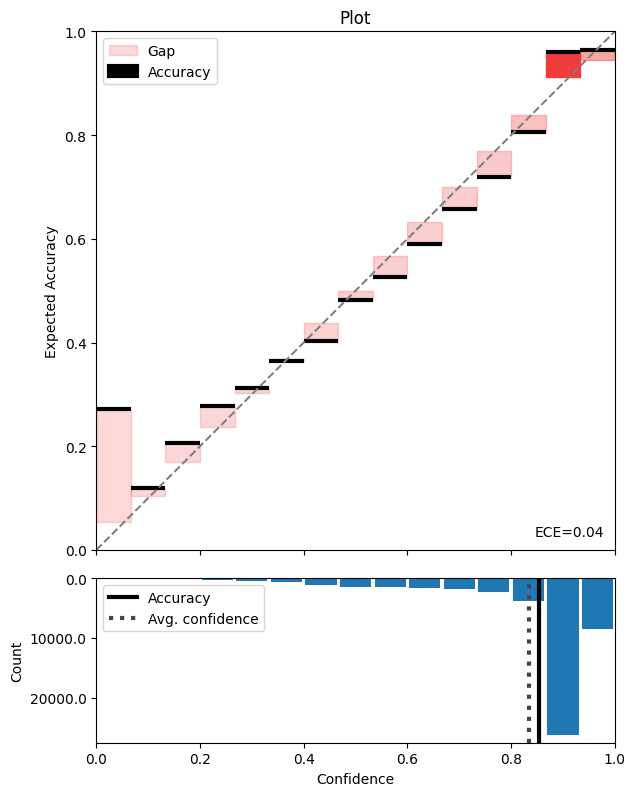

In [18]:
from plots import *

fig=reliability_diagram(true_labels=true_label, pred_labels=predictions, confidences=probabilities,
                        num_bins=15,
                        draw_ece=True,
                        draw_bin_importance="alpha",
                        draw_averages=True,
                        title="Plot", 
                        figsize=(6, 6),
                        dpi=100, 
                        return_fig=True)

# ViT Clip

In [20]:
model_name = "vit_base_patch16_clip_384"

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("device = ", device)

# create a ConvNeXt model : https://github.com/rwightman/pytorch-image-models/blob/master/timm/models/convnext.py
model = create_model(model_name, pretrained=True).to(device)

device =  cuda


model.safetensors:   0%|          | 0.00/347M [00:00<?, ?B/s]

c:\Users\Aerof\.conda\envs\PyTorch\Lib\site-packages\huggingface_hub\file_download.py:157: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Aerof\.cache\huggingface\hub\models--timm--vit_base_patch16_clip_384.laion2b_ft_in12k_in1k. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [36]:
from timm.data import OPENAI_CLIP_MEAN, OPENAI_CLIP_STD

NORMALIZE_MEAN = OPENAI_CLIP_MEAN
NORMALIZE_STD = OPENAI_CLIP_STD
SIZE = 384

# Here we resize smaller edge to 256, no center cropping
transforms = [
              T.Resize((SIZE,SIZE), interpolation=T.InterpolationMode.BICUBIC),
              T.ToTensor(),
              T.Normalize(NORMALIZE_MEAN, NORMALIZE_STD),
              ]

transforms = T.Compose(transforms)

In [37]:
import os
from tqdm import tqdm_notebook as tqdm
home=r"D:\aiml projects\Investigation on Vision Language Models\ImageNet\imagnet-1k-valid"

predictions=[]
true_label=[]
scores=[]
probabilities=[]

for label in tqdm(os.listdir(home)):
    for img_file in os.listdir(home+"/"+label):
        
        # importing and transforming image
        img=PIL.Image.open(os.path.join(home, label,img_file))
        img_tensor=transforms(img).unsqueeze(0).to(device) 
        # print(img_tensor.size())
        # getting outputs
        output=model(img_tensor)
        prediction=torch.argmax(output).cpu().tolist()
        score=torch.max(output).cpu().tolist()
        probability=torch.max(torch.softmax(output, dim=1)).cpu().tolist()
        
        # storing outputs in a list
        predictions.append(prediction)
        scores.append(score)
        probabilities.append(probability)
        true_label.append(label)
        

C:\Users\Aerof\AppData\Local\Temp\ipykernel_30432\2788254789.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for label in tqdm(os.listdir(home)):


  0%|          | 0/1000 [00:00<?, ?it/s]

In [38]:
# saving the outputs in a csv for future reference
import csv

data=zip(predictions, true_label, scores , probabilities)

with open("evaluated_ViT_CIP.csv","w") as f:
    writer=csv.writer(f)
    writer.writerows(data)
    print("succesful")
    f.close()

succesful


In [39]:
import pandas as pd

data=pd.read_csv("evaluated_ViT_CIP.csv")


In [40]:
data=data.dropna(axis=0,how='all')
data=data.reset_index()

In [41]:
data.columns

Index(['index', 'predictions', 'true_label', 'Output', 'probabilities'], dtype='object')

In [42]:
predictions=data['predictions'].to_numpy()
true_label=data['true_label'].to_numpy()
probabilities=data['probabilities'].to_numpy()

In [43]:
#caluculation of ECE

import numpy as np

def expected_calibration_error(predictions, true_label, probabilities, M=15):
    # uniform binning approach with M number of bins
    bin_boundaries = np.linspace(0, 1, M + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]

    
    accuracies= predictions==true_label
    
    ece = np.zeros(1)
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        # determine if sample is in bin m (between bin lower & upper)
        in_bin = np.logical_and(probabilities > bin_lower.item(), probabilities <= bin_upper.item())
        # can calculate the empirical probability of a sample falling into bin m: (|Bm|/n)
        prob_in_bin = in_bin.mean()

        if prob_in_bin.item() > 0:
            # get the accuracy of bin m: acc(Bm)
            accuracy_in_bin = accuracies[in_bin].mean()
            # get the average confidence of bin m: conf(Bm)
            avg_confidence_in_bin = probabilities[in_bin].mean()
            # calculate |acc(Bm) - conf(Bm)| * (|Bm|/n) for bin m and add to the total ECE
            ece += np.abs(avg_confidence_in_bin - accuracy_in_bin) * prob_in_bin
    return ece, accuracies

In [44]:
ECE, accuracies=expected_calibration_error(predictions=predictions, true_label=true_label, probabilities=probabilities)
ECE

array([0.12867546])

In [45]:
accuracies.sum()

43115

d:\aiml projects\Investigation on Vision Language Models\plots.py:176: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_yticklabels(new_ticks)


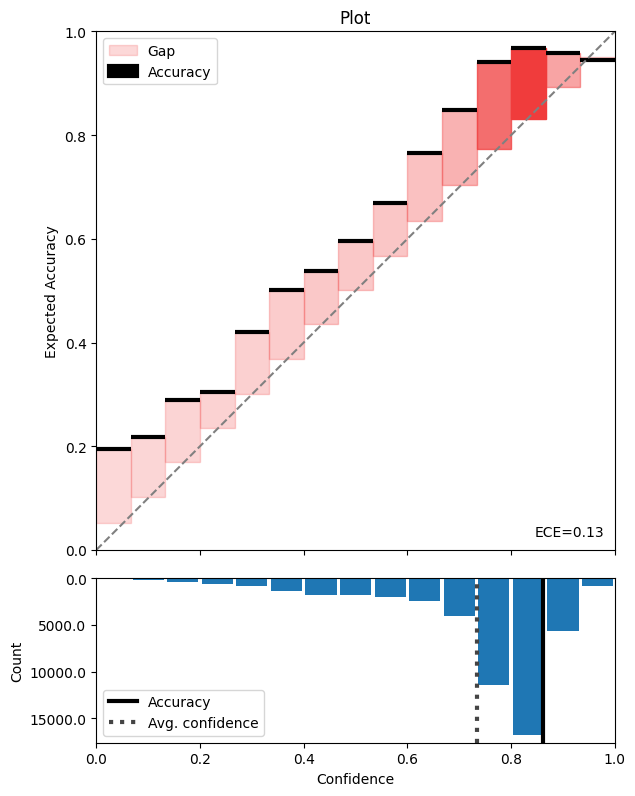

In [46]:
from plots import *

fig=reliability_diagram(true_labels=true_label, pred_labels=predictions, confidences=probabilities,
                        num_bins=15,
                        draw_ece=True,
                        draw_bin_importance="alpha",
                        draw_averages=True,
                        title="Plot", 
                        figsize=(6, 6),
                        dpi=100, 
                        return_fig=True)